In [1]:
pwd

'D:\\Thesis Work\\InitialDemoWork\\Cambridge_bigger USING LIBROSA'

### Imports

In [2]:
#kernel restarted for sleep, resume the thresholding work

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#from tqdm import tqdm_notebook

import sklearn.metrics as sklm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras import models
from keras.models import Model, load_model
from keras import callbacks
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


### Load Phone List

In [5]:
phones = np.load("phoneList.npy",allow_pickle=True)
phones = phones[(phones != 'sil') & (phones != 'sp') & (phones != 'spn')]
len(phones)

39

In [974]:
phone = 'R' #phones[39]
phone
#16 se age val inclusive

'R'

## X_train

In [975]:
X_train = np.load("./Cambridge_bigger Phones Train/"+phone+"_X.npy",allow_pickle=True)
print("Shape of X_train: ", X_train.shape)

Shape of X_train:  (7255, 13, 50, 3)


#### Min Max Normalization

In [976]:
Xmax = np.load("Cambridge_bigger Train MinMax/max_"+phone+".npy",allow_pickle=True)
Xmin = np.load("Cambridge_bigger Train MinMax/min_"+phone+".npy",allow_pickle=True)
X_train = (X_train - Xmin) / (Xmax - Xmin)
print(phone)
print(X_train.shape)

R
(7255, 13, 50, 3)


In [977]:
print(np.max(X_train,axis=(0,1,2)))
print(np.min(X_train,axis=(0,1,2)))
np.nan in X_train

[1.0 1.0 1.0]
[0.0 0.0 0.0]


False

## X_Validation

In [979]:
X_val = np.load("./Cambridge_bigger Phones Dev/"+phone+"_X.npy",allow_pickle=True)
y_val = np.ones(X_val.shape[0])
print("Total Samples validation (only correct phone): ", X_val.shape[0])
print("Shape of y_val (only correct yet): ", y_val.shape)

Total Samples validation (only correct phone):  1036
Shape of y_val (only correct yet):  (1036,)


In [980]:
for p in phones:
    if p != phone:
        notPhone = np.load('./Cambridge_bigger Phones Dev/'+p+'_X.npy',allow_pickle=True)
        notPhone = notPhone[:int(np.ceil(y_val.shape[0]/38))]
        X_val = np.vstack((X_val,notPhone))
    
print("Shape of y_val before adding mispronunciations: ",y_val.shape)
print("Shape of X_val after adding mispronunciations: ",X_val.shape)

Shape of y_val before adding mispronunciations:  (1036,)
Shape of X_val after adding mispronunciations:  (2083, 13, 50, 3)


In [981]:
y_val = np.hstack((y_val,np.zeros(X_val.shape[0]-y_val.shape[0])))
print("Shape of y_val after adding mispronunciations: ",y_val.shape)

Shape of y_val after adding mispronunciations:  (2083,)


#### Min Max Normalization

In [982]:
Xmax = np.load("Cambridge_bigger Train MinMax/max_"+phone+".npy", allow_pickle=True)
Xmin = np.load("Cambridge_bigger Train MinMax/min_"+phone+".npy", allow_pickle=True)
X_val = (X_val - Xmin) / (Xmax - Xmin)
print(phone)
print(X_val.shape)

R
(2083, 13, 50, 3)


## Model Training

In [1005]:
input_img = Input(shape=(13, 50, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(64, (2, 3), activation='relu', padding='valid')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (3, 12, 32)

x = BatchNormalization()(encoded)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
decoded = Conv2DTranspose(3, (2, 3), activation='relu', padding='valid')(x)

autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer= keras.optimizers.Adam(), loss='mean_squared_error');

In [1006]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 13, 50, 3)         0         
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 12, 48, 64)        1216      
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 6, 24, 64)         0         
_________________________________________________________________
batch_normalization_169 (Bat (None, 6, 24, 64)         256       
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 6, 24, 128)        73856     
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 3, 12, 128)        0         
_________________________________________________________________
batch_normalization_170 (Bat (None, 3, 12, 128)        512       
__________

In [1013]:
callbacklist=[callbacks.History(),callbacks.ModelCheckpoint('./Models/'+phone+'.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)]
autoencoder.fit(X_train, X_train, batch_size=128, epochs=400, callbacks=callbacklist,validation_data=(X_val[y_val == 1],X_val[y_val == 1]))

Train on 7255 samples, validate on 1036 samples
Epoch 1/5
7255/7255 [==============================] - 3s 434us/step - loss: 0.0055 - val_loss: 0.0119

Epoch 00001: val_loss improved from inf to 0.01194, saving model to ./lessModels/R.h5
Epoch 2/5
7255/7255 [==============================] - 3s 397us/step - loss: 0.0041 - val_loss: 0.0110

Epoch 00002: val_loss improved from 0.01194 to 0.01095, saving model to ./lessModels/R.h5
Epoch 3/5
7255/7255 [==============================] - 3s 397us/step - loss: 0.0031 - val_loss: 0.0087

Epoch 00003: val_loss improved from 0.01095 to 0.00869, saving model to ./lessModels/R.h5
Epoch 4/5
7255/7255 [==============================] - 3s 400us/step - loss: 0.0027 - val_loss: 0.0063

Epoch 00004: val_loss improved from 0.00869 to 0.00629, saving model to ./lessModels/R.h5
Epoch 5/5
7255/7255 [==============================] - 3s 403us/step - loss: 0.0025 - val_loss: 0.0046

Epoch 00005: val_loss improved from 0.00629 to 0.00457, saving model to ./le

In [991]:
history = _

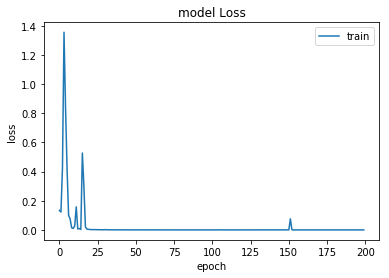

In [993]:
plt.plot(history.history['val_loss'])
# plt.plot(history['val_loss'])
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

## Thresholding & Evaluation

### X_Validation + Thresholding

In [3]:
from tqdm import tqdm_notebook

In [101]:
thresholdList = []
for phone in tqdm_notebook(phones):
    print("\n\n------->>>>>>Phone: ", phone)
    print()
    X_val = np.load("./Cambridge_bigger Phones Dev/"+phone+"_X.npy",allow_pickle=True)
    y_val = np.ones(X_val.shape[0])
    print("Total Samples validation (only correct phone): ", X_val.shape[0])
    print("Shape of y_val (only correct yet): ", y_val.shape)
    
    print("\n-----------ADDING MISPRONUNCIATIONS-----------\n")
    
    for p in phones:
        if p != phone:
            notPhone = np.load('./Cambridge_bigger Phones Dev/'+p+'_X.npy',allow_pickle=True)
            notPhone = notPhone[:int(np.ceil(y_val.shape[0]/38))]
            X_val = np.vstack((X_val,notPhone))

    print("Shape of y_val before adding mispronunciations: ",y_val.shape)
    print("Shape of X_val after adding mispronunciations: ",X_val.shape)
    
    y_val = np.hstack((y_val,np.zeros(X_val.shape[0]-y_val.shape[0])))
    print("Shape of y_val after adding mispronunciations: ",y_val.shape)
    
    print("\n-----------MIN-MAX NORMALISATION-----------\n")
    
    Xmax = np.load("Cambridge_bigger Train MinMax/max_"+phone+".npy", allow_pickle=True)
    Xmin = np.load("Cambridge_bigger Train MinMax/min_"+phone+".npy", allow_pickle=True)
    X_val = (X_val - Xmin) / (Xmax - Xmin)
    print("X_val shape: ", X_val.shape)
    
    print("\n-----------THRESHOLDING-----------\n")
    
    autoencoder = load_model("./Models/"+phone+".h5")
    
    validationSetLength = X_val.shape[0]
    accs = []
    f1mis = []

    y_val_mses = np.array([autoencoder.evaluate(X_val[i:i+1],X_val[i:i+1],verbose=0) for i in range(validationSetLength)])
    
    print("Total Thresholds: ",y_val_mses.size)
    
    for threshold in sorted(y_val_mses): #ek ek kar k put in +ve
        y_pred = 1*(y_val_mses <= threshold)

        accs.append(sklm.accuracy_score(y_val,y_pred))
        f1mis.append(sklm.precision_recall_fscore_support(y_val,y_pred)[2][0])

    print("Max Achievable Accuracy (Overall): ", max(accs))
    print("Max Achievable Accuracy (Overall) on Threshold: ", np.argmax(accs))

    print("Max Achievable F-1 score Threshold: ", sorted(y_val_mses)[np.argmax(f1mis)])
    print("Max Achievable Accuracy On This Threshold: ", accs[np.argmax(f1mis)])
    print("Max Achievable F-1 score for Mispronunciations: ", max(f1mis))
    print("============================================")
    thresholdList.append(sorted(y_val_mses)[np.argmax(f1mis)])



------->>>>>>Phone:  AA

Total Samples validation (only correct phone):  388
Shape of y_val (only correct yet):  (388,)

-----------ADDING MISPRONUNCIATIONS-----------

Shape of y_val before adding mispronunciations:  (388,)
Shape of X_val after adding mispronunciations:  (806, 13, 50, 3)
Shape of y_val after adding mispronunciations:  (806,)

-----------MIN-MAX NORMALISATION-----------

X_val shape:  (806, 13, 50, 3)

-----------THRESHOLDING-----------

Total Thresholds:  806


D:\Anaconda3\envs\thesisWork\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Max Achievable Accuracy (Overall):  0.7481389578163772
Max Achievable Accuracy (Overall) on Threshold:  466
Max Achievable F-1 score Threshold:  0.00012807929306291044
Max Achievable Accuracy On This Threshold:  0.728287841191067
Max Achievable F-1 score for Mispronunciations:  0.746820809248555


------->>>>>>Phone:  R

Total Samples validation (only correct phone):  1036
Shape of y_val (only correct yet):  (1036,)

-----------ADDING MISPRONUNCIATIONS-----------

Shape of y_val before adding mispronunciations:  (1036,)
Shape of X_val after adding mispronunciations:  (2083, 13, 50, 3)
Shape of y_val after adding mispronunciations:  (2083,)

-----------MIN-MAX NORMALISATION-----------

X_val shape:  (2083, 13, 50, 3)

-----------THRESHOLDING-----------

Total Thresholds:  2083
Max Achievable Accuracy (Overall):  0.6634661545847336
Max Achievable Accuracy (Overall) on Threshold:  1190
Max Achievable F-1 score Threshold:  7.125100091798231e-05
Max Achievable Accuracy On This Threshold:  0


X_val shape:  (2678, 13, 50, 3)

-----------THRESHOLDING-----------

Total Thresholds:  2678
Max Achievable Accuracy (Overall):  0.570201643017177
Max Achievable Accuracy (Overall) on Threshold:  1604
Max Achievable F-1 score Threshold:  7.064906822051853e-05
Max Achievable Accuracy On This Threshold:  0.4955190440627334
Max Achievable F-1 score for Mispronunciations:  0.6626716604244695


------->>>>>>Phone:  L

Total Samples validation (only correct phone):  1239
Shape of y_val (only correct yet):  (1239,)

-----------ADDING MISPRONUNCIATIONS-----------

Shape of y_val before adding mispronunciations:  (1239,)
Shape of X_val after adding mispronunciations:  (2462, 13, 50, 3)
Shape of y_val after adding mispronunciations:  (2462,)

-----------MIN-MAX NORMALISATION-----------

X_val shape:  (2462, 13, 50, 3)

-----------THRESHOLDING-----------

Total Thresholds:  2462
Max Achievable Accuracy (Overall):  0.6246953696181966
Max Achievable Accuracy (Overall) on Threshold:  1742
Max Achie

Shape of y_val before adding mispronunciations:  (73,)
Shape of X_val after adding mispronunciations:  (149, 13, 50, 3)
Shape of y_val after adding mispronunciations:  (149,)

-----------MIN-MAX NORMALISATION-----------

X_val shape:  (149, 13, 50, 3)

-----------THRESHOLDING-----------

Total Thresholds:  149
Max Achievable Accuracy (Overall):  0.8120805369127517
Max Achievable Accuracy (Overall) on Threshold:  74
Max Achievable F-1 score Threshold:  0.00019518860790412873
Max Achievable Accuracy On This Threshold:  0.8053691275167785
Max Achievable F-1 score for Mispronunciations:  0.8152866242038217


------->>>>>>Phone:  ZH

Total Samples validation (only correct phone):  19
Shape of y_val (only correct yet):  (19,)

-----------ADDING MISPRONUNCIATIONS-----------

Shape of y_val before adding mispronunciations:  (19,)
Shape of X_val after adding mispronunciations:  (57, 13, 50, 3)
Shape of y_val after adding mispronunciations:  (57,)

-----------MIN-MAX NORMALISATION-----------

X_

In [102]:
thresholdList

[0.00012807929306291044,
 7.125100091798231e-05,
 0.0002498737012501806,
 0.00010430155816720799,
 0.00015716307098045945,
 4.8752815928310156e-05,
 0.0001825416402425617,
 7.563297549495474e-05,
 0.00028608462889678776,
 0.00012159281322965398,
 7.064906822051853e-05,
 0.00018254542374052107,
 0.0001360509922960773,
 9.136499284068123e-05,
 6.271767779253423e-05,
 0.0001311873202212155,
 0.00018645613454282284,
 0.00021155158174224198,
 7.06714199623093e-05,
 0.000133056819322519,
 9.751477773534134e-05,
 0.00011291639384580776,
 0.00013533400488086045,
 0.0001840930199250579,
 0.00013978917559143156,
 0.005230588838458061,
 0.0002748692349996418,
 0.00019673512724693865,
 0.00027719757054001093,
 6.75226838211529e-05,
 0.00019518860790412873,
 0.0003405849856790155,
 0.00011024715786334127,
 0.028261519968509674,
 0.00012027470074826851,
 0.00019116407202091068,
 0.00039200676837936044,
 0.0003817185643129051,
 0.0001687565672909841]

### Thresholding

## Testing

### X_test + Predictions

In [109]:
f1ScoresList = []
for t,phone in enumerate(tqdm_notebook(phones)):
    print("\n\n------->>>>>>Phone: ", phone)
    print()
    X_test = np.load("./Cambridge_bigger Phones Test/"+phone+"_X.npy",allow_pickle=True)
    y_test = np.ones(X_test.shape[0])

    print("Total Samples test (only correct phone): ", X_test.shape[0])
    print("Shape of y_test (only correct yet): ", y_test.shape)
    
    print("\n-----------ADDING MISPRONUNCIATIONS-----------\n")
    
    for p in phones:
        if p != phone:
            notPhone = np.load("./Cambridge_bigger Phones Test/"+p+'_X.npy',allow_pickle=True)
            notPhone = notPhone[:int(np.ceil(y_test.shape[0]/38))]
            X_test = np.vstack((X_test,notPhone))

    print("Shape of y_test before adding mispronunciations: ",y_test.shape)
    print("Shape of X_test after adding mispronunciations: ",X_test.shape)
    
    y_test = np.hstack((y_test,np.zeros(X_test.shape[0] - y_test.shape[0])))
    print("Shape of y_test after adding mispronunciations: ",y_test.shape)
    
    print("\n-----------MIN-MAX NORMALISATION-----------\n")
    
    Xmax = np.load("Cambridge_bigger Train MinMax/max_"+phone+".npy",allow_pickle=True)
    Xmin = np.load("Cambridge_bigger Train MinMax/min_"+phone+".npy",allow_pickle=True)
    X_test = (X_test - Xmin) / (Xmax - Xmin)
    print("X_test Shape: ",X_test.shape)
    
    print("\n-----------PREDICTING-----------\n")
    
    autoencoder = load_model("./Models/"+phone+".h5")
    
    y_pred = [1 if autoencoder.evaluate(X_test[i:i+1],X_test[i:i+1],verbose=0)<=thresholdList[t]\
     else 0 for i in range(X_test.shape[0])]
    
    print("Phone: ",phone)
    print(classification_report(y_test, y_pred, target_names=['Mispronounced','Correct']))
    print(confusion_matrix(y_test, y_pred, labels=range(2)))

    print(sklm.roc_curve(y_test,y_pred))
    print('FAR = ', sklm.roc_curve(y_test,y_pred)[0][1]*100,'%')
    print('FRR = ', (1 - sklm.roc_curve(y_test,y_pred)[1][1])*100,'%')
    print("AUC_SCORE = ", sklm.roc_auc_score(y_test,y_pred)*100,'%')
    print("============================================")
    f1ScoresList.append(sklm.precision_recall_fscore_support(y_test,y_pred)[2][0])



------->>>>>>Phone:  AA

Total Samples test (only correct phone):  778
Shape of y_test (only correct yet):  (778,)

-----------ADDING MISPRONUNCIATIONS-----------

Shape of y_test before adding mispronunciations:  (778,)
Shape of X_test after adding mispronunciations:  (1576, 13, 50, 3)
Shape of y_test after adding mispronunciations:  (1576,)

-----------MIN-MAX NORMALISATION-----------

X_test Shape:  (1576, 13, 50, 3)

-----------PREDICTING-----------

Phone:  AA
               precision    recall  f1-score   support

Mispronounced       0.70      0.78      0.73       798
      Correct       0.74      0.65      0.69       778

    micro avg       0.71      0.71      0.71      1576
    macro avg       0.72      0.71      0.71      1576
 weighted avg       0.72      0.71      0.71      1576

[[620 178]
 [272 506]]
(array([0.        , 0.22305764, 1.        ]), array([0.       , 0.6503856, 1.       ]), array([2, 1, 0]))
FAR =  22.305764411027567 %
FRR =  34.96143958868895 %
AUC_SCORE =


[[1772  107]
 [1537  346]]
(array([0.        , 0.05694518, 1.        ]), array([0.        , 0.18374934, 1.        ]), array([2, 1, 0]))
FAR =  5.694518360830228 %
FRR =  81.6250663834307 %
AUC_SCORE =  56.340207627869546 %


------->>>>>>Phone:  S

Total Samples test (only correct phone):  2512
Shape of y_test (only correct yet):  (2512,)

-----------ADDING MISPRONUNCIATIONS-----------

Shape of y_test before adding mispronunciations:  (2512,)
Shape of X_test after adding mispronunciations:  (4995, 13, 50, 3)
Shape of y_test after adding mispronunciations:  (4995,)

-----------MIN-MAX NORMALISATION-----------

X_test Shape:  (4995, 13, 50, 3)

-----------PREDICTING-----------

Phone:  S
               precision    recall  f1-score   support

Mispronounced       0.72      0.76      0.74      2483
      Correct       0.75      0.71      0.73      2512

    micro avg       0.74      0.74      0.74      4995
    macro avg       0.74      0.74      0.74      4995
 weighted avg       0.74  

D:\Anaconda3\envs\thesisWork\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


               precision    recall  f1-score   support

Mispronounced       0.50      1.00      0.66      2658
      Correct       0.00      0.00      0.00      2701

    micro avg       0.50      0.50      0.50      5359
    macro avg       0.25      0.50      0.33      5359
 weighted avg       0.25      0.50      0.33      5359

[[2658    0]
 [2701    0]]
(array([0., 1.]), array([0., 1.]), array([1, 0]))
FAR =  100.0 %
FRR =  0.0 %
AUC_SCORE =  50.0 %


D:\Anaconda3\envs\thesisWork\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)




------->>>>>>Phone:  L

Total Samples test (only correct phone):  2480
Shape of y_test (only correct yet):  (2480,)

-----------ADDING MISPRONUNCIATIONS-----------

Shape of y_test before adding mispronunciations:  (2480,)
Shape of X_test after adding mispronunciations:  (4928, 13, 50, 3)
Shape of y_test after adding mispronunciations:  (4928,)

-----------MIN-MAX NORMALISATION-----------

X_test Shape:  (4928, 13, 50, 3)

-----------PREDICTING-----------

Phone:  L
               precision    recall  f1-score   support

Mispronounced       0.51      0.96      0.67      2448
      Correct       0.70      0.10      0.17      2480

    micro avg       0.53      0.53      0.53      4928
    macro avg       0.61      0.53      0.42      4928
 weighted avg       0.61      0.53      0.42      4928

[[2345  103]
 [2236  244]]
(array([0.        , 0.04207516, 1.        ]), array([0.       , 0.0983871, 1.       ]), array([2, 1, 0]))
FAR =  4.207516339869281 %
FRR =  90.16129032258064 %
AUC_SCO


[[849 329]
 [321 837]]
(array([0.        , 0.27928693, 1.        ]), array([0.        , 0.72279793, 1.        ]), array([2, 1, 0]))
FAR =  27.928692699490664 %
FRR =  27.72020725388601 %
AUC_SCORE =  72.17555002331166 %


------->>>>>>Phone:  V

Total Samples test (only correct phone):  548
Shape of y_test (only correct yet):  (548,)

-----------ADDING MISPRONUNCIATIONS-----------

Shape of y_test before adding mispronunciations:  (548,)
Shape of X_test after adding mispronunciations:  (1118, 13, 50, 3)
Shape of y_test after adding mispronunciations:  (1118,)

-----------MIN-MAX NORMALISATION-----------

X_test Shape:  (1118, 13, 50, 3)

-----------PREDICTING-----------

Phone:  V
               precision    recall  f1-score   support

Mispronounced       0.69      0.84      0.76       570
      Correct       0.79      0.61      0.69       548

    micro avg       0.73      0.73      0.73      1118
    macro avg       0.74      0.73      0.73      1118
 weighted avg       0.74      0.


[[299  43]
 [154 176]]
(array([0.        , 0.12573099, 1.        ]), array([0.        , 0.53333333, 1.        ]), array([2, 1, 0]))
FAR =  12.573099415204677 %
FRR =  46.666666666666664 %
AUC_SCORE =  70.38011695906432 %


------->>>>>>Phone:  Z

Total Samples test (only correct phone):  436
Shape of y_test (only correct yet):  (436,)

-----------ADDING MISPRONUNCIATIONS-----------

Shape of y_test before adding mispronunciations:  (436,)
Shape of X_test after adding mispronunciations:  (892, 13, 50, 3)
Shape of y_test after adding mispronunciations:  (892,)

-----------MIN-MAX NORMALISATION-----------

X_test Shape:  (892, 13, 50, 3)

-----------PREDICTING-----------

Phone:  Z
               precision    recall  f1-score   support

Mispronounced       0.74      0.88      0.80       456
      Correct       0.84      0.67      0.75       436

    micro avg       0.78      0.78      0.78       892
    macro avg       0.79      0.78      0.77       892
 weighted avg       0.79      0.78


[[237  29]
 [147 111]]
(array([0.        , 0.10902256, 1.        ]), array([0.        , 0.43023256, 1.        ]), array([2, 1, 0]))
FAR =  10.902255639097744 %
FRR =  56.97674418604651 %
AUC_SCORE =  66.06050008742787 %


------->>>>>>Phone:  CH

Total Samples test (only correct phone):  222
Shape of y_test (only correct yet):  (222,)

-----------ADDING MISPRONUNCIATIONS-----------

Shape of y_test before adding mispronunciations:  (222,)
Shape of X_test after adding mispronunciations:  (450, 13, 50, 3)
Shape of y_test after adding mispronunciations:  (450,)

-----------MIN-MAX NORMALISATION-----------

X_test Shape:  (450, 13, 50, 3)

-----------PREDICTING-----------

Phone:  CH
               precision    recall  f1-score   support

Mispronounced       0.64      0.83      0.73       228
      Correct       0.75      0.53      0.62       222

    micro avg       0.68      0.68      0.68       450
    macro avg       0.70      0.68      0.67       450
 weighted avg       0.70      0.6

In [110]:
f1ScoresList

[0.7337278106508875,
 0.6814175211368951,
 0.8432010409889394,
 0.7721206129510627,
 0.7738271604938272,
 0.6821966902076526,
 0.7489130434782608,
 0.6831148804934464,
 0.7409295940380467,
 0.6932482721956407,
 0.6630909317699888,
 0.6672357376582729,
 0.7820015515903801,
 0.7127500340182337,
 0.7105855855855856,
 0.7857927499084585,
 0.8860528714676389,
 0.7438692098092643,
 0.723168654173765,
 0.7616785431512272,
 0.6601036269430052,
 0.77506199078994,
 0.6903973509933775,
 0.6307692307692309,
 0.7858546168958743,
 0.8663793103448276,
 0.7522012578616352,
 0.802,
 0.7690677966101694,
 0.6871247498332221,
 0.8363636363636364,
 0.8222222222222223,
 0.6819615715514769,
 0.6621621621621622,
 0.7292307692307691,
 0.7265774378585085,
 0.7901234567901234,
 0.8345323741007195,
 0.7950310559006211]

In [115]:
print("Mean F1 Score: ", round(np.mean(f1ScoresList),2)*100,"%")

Mean F1 Score:  75.0 %


In [117]:
import scipy.stats as ss

In [120]:
ss.hmean(f1ScoresList)

0.740692698026801